## Dylan Schlichting, OCNG 651 Midterm Project: Statistical Atmosphere Model for the Tropics





### Instructions

Based on the Gill model, we can assume that the wave adjustment within the equatorial wave guide is sufficiently fast so that the surface wind response to SST changes can be considered instantaneous on climate time scales. As such, surface wind stress anomalies in the tropics can be simply written as: $T = T_s + T_n$ where $T_s$
is a state vector of the surface wind stress anomalies driven by SST anomalies and $T_n$ is a state vector of the wind stress anomalies caused by weather noise, which is not related to SSTA.

If we further assume that $T_s$ is linearly related to SSTA, then $T_s$ can be modeled
as: $T_s = C T$ , where $T$ is a state vector of SSTA and $C$ is a constant matrix relating
SSTA to wind stress anomalies. $C$ can be determined statistically from
observations. Once determined, $T_s = C T$ represents a statistical atmosphere
model. In this project, you are asked to derive $C$ using Singular Value
Decomposition (SVD) analysis on observed monthly SSTA and wind stress
anomalies.
The following is a description of the datasets and analysis methods:

Datasets: NCEP reanalysis monthly mean data from Jan. 1948 to Sep. 2017.

* Surface temperature ( skt.sfc.mon.mean.tropics.nc
* zonal wind stress ( uflx.sfc.mon.mean.tropics.nc )
* meridional wind stress ( vflx.sfc.mon.mean.tropics.nc )
* land mask ( lsmask.tropics.nc
* All the data files are in netcdf format and are between 30S and 30N
* Matlab script (step1_read_input.m) shows you how to read the data, generate anomalies and compute standard deviation for each of the variables


Analysis: SVD analysis ( Bretherton et al. 1992, Syu et al. 1999, Chang et al. 2001)
* Divide the data into two periods, say the first period from 1948 to 1999 and the second period from 2000 to 2017

* Take the data in one period, say the first period 1948 1999, to perform SVD analysis
* Normalize all the anomaly fields by dividing each of the variables by its standard deviation computed by step1_read_input.m
*  Form a state vector for SSTA, T , and another one for zonal and meridional wind stresses, $T_s$. Note that $T_s$  contains both wind stress component and has larger dimension than T
* Form a covariance matrix, A $<T_s T'>$, whose dimension should be MxN , where M is the length for $T_s$  and N is length for T
* Apply SVD on A by calling Matlab’s SVD function, which results in A=USV, where S is a diagonal matrix with diagonal elements representing singular values explained squared covariance in each SVD, U contains all wind stress singular vectors and V contains all SST singular vectors, which are self orthogonal, i.e., VV’ I and UU’ I

SST and wind stress PC time series are highly correlated and normalized.
Therefore, we can assume that they are equal to each other. This allows us to
construct a statistical atmosphere model:
* Take any SSTA state vector at any given time from the second period, T , normalize it by the standard deviation, and then project it onto a leading SST SVD mode, $v_i$ , to obtain a time series $v_i = <v_i'T>/<v_i'v_i>$

* Take $b_i$ as the corresponding time series for the i th wind stress SVD, $u_i$ , and multiply $b_i$ to $u_i$ ; $b_iu_i$ represents the wind stress variation driven by the $i^{th}$ SST SVD, $v_i$
* Add all $b_iu_i$ for first J (say J=6) leading SDVs, $\Sigma^J b_iu_i$ , and multiply it by the standard deviation of the wind stress; we obtain wind stress anomalies driven by the SST anomaly at that time
* Repeat the above for all time points in the second period, we obtain a wind stress anomaly driven by SSTA during the entire second period
* Validate the skill of this statistical atmosphere model against observations by computing correlations between modeled and observed wind stresses at each grid point

#### Import relevant packages

In [1]:
#Standard array stuff
import pandas as pd
import numpy as np
import xarray as xr

#Plotting packages
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo

#Statistics 
from sklearn.linear_model import LinearRegression
from scipy import stats

#supress warnings bc python yells at me
import warnings
warnings.filterwarnings("ignore") 

#### Open the data and select the first time series.

In [2]:
#Open Data
paths = ['uflx.sfc.mon.mean.tropics.nc',
         'vflx.sfc.mon.mean.tropics.nc',
         'skt.sfc.mon.mean.tropics.nc'
        ]  
ds = xr.open_mfdataset(paths)

#Select between 100-300 deg longitude, -30-30 deg latitude between 1948 and 1999
ds1 = ds.sel(lat = slice(30,-30),
             lon = slice(100,300),
             time = slice('1948','1999'),
            )

#xarray produces different array dimensions than matlab, so tranpose first. 
sst = ds1.skt.transpose('lat','lon','time')
taux = ds1.uflx.transpose('lat','lon','time')
tauy = ds1.vflx.transpose('lat','lon','time')

#### Remove the seasonality from the data. 
Python does not have a repmat function for data larger than 2D. The closest thing we have here is groupby, so I will remove the seasonality by grouping the data by month from the entire data period, calculate the mean, then subtract it.

In [3]:
sstm = sst.groupby("time.month").mean("time")
tauxm = taux.groupby("time.month").mean("time")
tauym = tauy.groupby("time.month").mean("time")


ssta = np.array(sst.groupby("time.month")-sstm)
tauxa = np.array(taux.groupby("time.month")-tauxm)
tauya = np.array(tauy.groupby("time.month")-tauym)

#Compute the std of the anomalies
sigma_sst = ssta.std()
sigma_taux = tauxa.std()
sigma_tauy = tauya.std()

print('SST Standard Deviation: ',sigma_sst)
print('TauX Standard Deviation: ',sigma_taux)
print('TauY Standard Deviation: ',sigma_tauy)

SST Standard Deviation:  0.66261005
TauX Standard Deviation:  0.023798805
TauY Standard Deviation:  0.018562352


Which matches the output values from Matlab, so we have succesfully recreated the input script.

#### Next, use gridfile to create a mask to filter out land values.

In [22]:
maskpath =  ('lsmask.tropics.nc')     
mask = xr.open_mfdataset(maskpath)
mask = mask.sel(lat=slice(30,-30),lon=slice(100,300))

#Extract coordinates from mask
lat = np.array(mask.lat)
lon = np.array(mask.lon)

mask = mask.lsmask+1
mask = np.squeeze(mask.sel(lat=slice(30,-30),lon=slice(100,300)))

for i in range(len(ssta[0,0,:])):
    ssta[:,:,i] = ssta[:,:,i]*mask[:,:]
    tauxa[:,:,i] = tauxa[:,:,i]*mask[:,:]
    tauya[:,:,i] = tauya[:,:,i]*mask[:,:]

#### Form state vectors for sst $T$ and wind stress $Ts$, noting $Ts$ will have an extra dimension because we are combining the x and y components

In [5]:
#Divide by the anomalies to normalize the data
T1 = ssta/sigma_sst
Tx1 = tauxa/sigma_taux
Ty1 = tauya/sigma_tauy

T = np.reshape(T1, (32*107, 624), order = 'F') #Have to do order ='F' for matlab style reshaping.

Tx1 = np.reshape(Tx1, (32*107, 624), order = 'F')
Ty1 = np.reshape(Ty1, (32*107, 624), order = 'F')
Ts = np.concatenate((Tx1,Ty1), axis=0)

print(np.shape(T))
print(np.shape(Ts))

(3424, 624)
(6848, 624)


#### Calculate the covariance matrix whose length is MxN, where M is the length for Ts and N is the length for T. To get the covariance $A = <T_sT'>$, where the $'$ denotes transpose. Note we need to use the dot product here to sum over all anomalies.

In [6]:
A = np.matmul(Ts,T.T)/623
print(np.shape(A))

(6848, 3424)


#### Perform the SVD with scipy's built in function. Note that it is slightly different than matlab. 
Per the docs, in matlab: [U,S,V]=svd(a), whereas in Python: [U, S, V.T] = linalg.svd(a), so we need to transpose it. The difference here is that S is a vector representing the singular valeus in Python, whereas matlab the diagonol matrix is returned

In [7]:
u,s,vt = np.linalg.svd(A, full_matrices=True)
v = vt.T 
print(np.shape(u))
print(np.shape(s))
print(np.shape(vt))

(6848, 6848)
(3424,)
(3424, 3424)


Let's look at the % variance explained by each mode. Since the singular values represent the 2-norm of the covariance matrix, we compute it $(s_i)^2/ \Sigma (s)^2$

In [8]:
var = []

for i in range(6):
    var.append((s[i]**2)/(s**2).sum()*100)
    print('Mode '+ str(i)+': [%]',((s[i]**2)/(s**2).sum())*100)

Mode 0: [%] 73.59657584576124
Mode 1: [%] 8.93202699433681
Mode 2: [%] 6.563405801979188
Mode 3: [%] 2.477056098128606
Mode 4: [%] 1.67233978340542
Mode 5: [%] 1.135551759578964


####  Calculate a time series for each SVD mode. 
To do this, we need to project $T$ and $Ts$ onto each SST and SVD mode, respectively, to obtain the i$^{th}$ PC time series. This takes the form: $b_i = <v_i'T>/<v_i'v_i>$ and $d_i = <u_i'T>/<u_i'u_i>$, where $b_i$ is the SST SVD mode and $d_i$ is the wind stress SVD mode, respectively. 

In [9]:
b = []
d = []
r = []

for i in range(4):
    b.append(np.dot(v[:,i].T,T)/np.dot(v[:,i].T,v[:,i]))
    d.append(np.dot(u[:,i].T,Ts)/np.dot(u[:,i].T,u[:,i]))
    r.append(np.corrcoef(b[i],d[i])[1,0])
    print('Correlation Coefficient for PC' + str(i)+':', round(np.corrcoef(b[i],d[i])[1,0], 3))
b = np.array(b)
d = np.array(d)
r = np.array(r)

Correlation Coefficient for PC0: 0.804
Correlation Coefficient for PC1: 0.7
Correlation Coefficient for PC2: 0.608
Correlation Coefficient for PC3: 0.54


#### Plot time series of the first four principle components (PCs).
Note that I had to plot the negative of the observed PCs to replicate the time series plots in the assignment description.

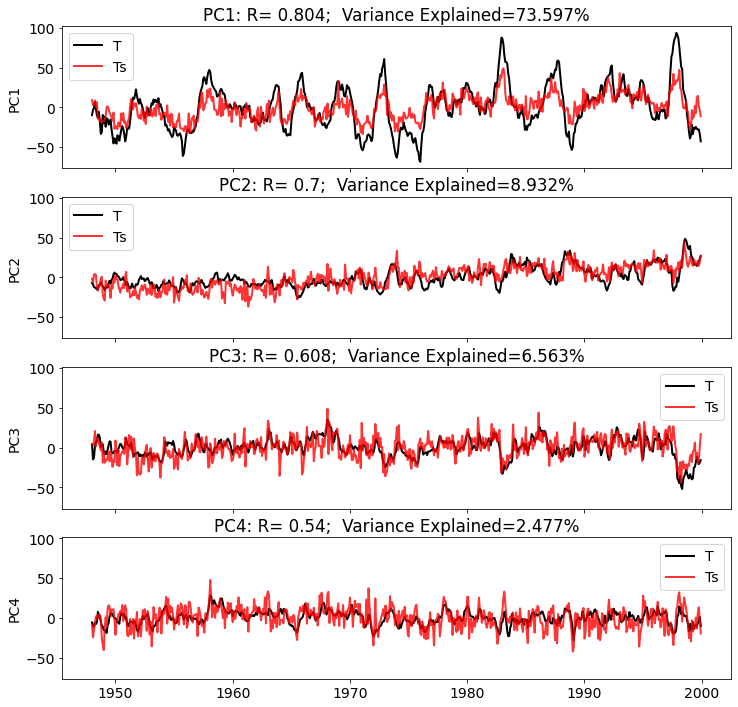

In [10]:
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(4,1, figsize=(12,12), sharey = True)
for item in range(len(ax)):
    ax[item].plot(ds1.time.values,-b[item,:], lw = 2, color = 'k', label = 'T')
    ax[item].plot(ds1.time.values,-d[item,:], alpha = 0.8, lw = 2, color = 'r', label = 'Ts')
    ax[item].set_title('PC'+str(item+1)+
                       ': R= '+str(round(r[item],3))+ ';  '
                       'Variance Explained='+
                        str(round(var[item],3))+'%')
    ax[item].legend()
    ax[item].set_ylabel('PC'+str(item+1))
for item in range(len(ax)-1):
    ax[item].set_xticklabels([])

So far, the PC time series match the expected results from assignment sheet. The first mode explains the majority of the variance, with a periodicity of several years, which likely corresponds the El-nino component of ENSO or similar modes of variability. This should also be characterized by a weakening of eastward winds in the tropical Pacific. Next, let's reconstruct the modes to plot them in space. If the first mode is physically representative of El Nino - we would expect to see a warming of SST in the Pacific. 

In [11]:
#Extract the first 4 leading SVDs and reshape arrays back to lat-lon dimensions
vrs = [] #rs = reshape array back to lat lon
txrs = []
tyrs = []
for i in range(4):
    vrs.append(np.reshape(vt[i,:],(32,107),order='F'))
    
    tausplit = np.split(u[:,i],2,axis=0)
    txrs.append(np.reshape(np.array(tausplit[0]),(32,107),order='F'))
    tyrs.append(np.reshape(np.array(tausplit[1]),(32,107),order='F'))
    
vrs = np.array(vrs)*-1
uxrs = np.array(txrs)*-1
uyrs = np.array(tyrs)*-1

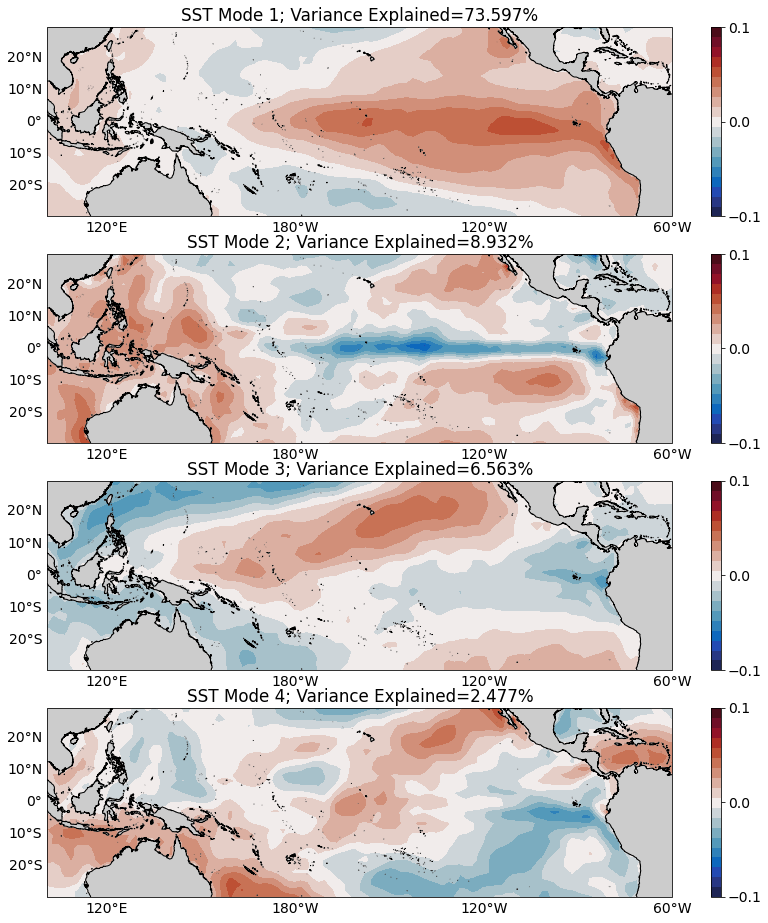

In [12]:
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                edgecolor='face',
                                facecolor=cfeature.COLORS['land'])

states_provinces = cfeature.NaturalEarthFeature(
                   category='cultural',
                   name='admin_1_states_provinces_lines',
                   scale='10m',
                   facecolor='none')

fig,ax = plt.subplots(4,1, figsize = (14,16),  
                      subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-180)},
                     )
# fig.tight_layout()
for i in range(4):
    mappable =  ax[i].contourf(lon, 
                               lat, 
                               vrs[i,:,:], 
                               levels = np.linspace(-0.1,0.1,20),
                               cmap = cmo.balance, 
                               transform = ccrs.PlateCarree()
                             )
    #Colorbar & more cartopy
    cb = fig.colorbar(mappable, 
                      ax = ax[i],
                      ticks = [-0.1, 0, 0.1],
                      orientation='vertical', 
                      label = ''
                     )
    ax[i].set_aspect('auto')
    ax[i].add_feature(land_10m, facecolor='0.8')
    ax[i].coastlines(resolution='10m')  
    #Gridlines - make it look pretty
    
    ax[i].set_title('SST Mode '+str(i+1) +'; Variance Explained='+
                        str(round(var[i],3))+'%')
    
    gl = ax[i].gridlines(linewidth=0.4, color='black', alpha=0, draw_labels=True)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False

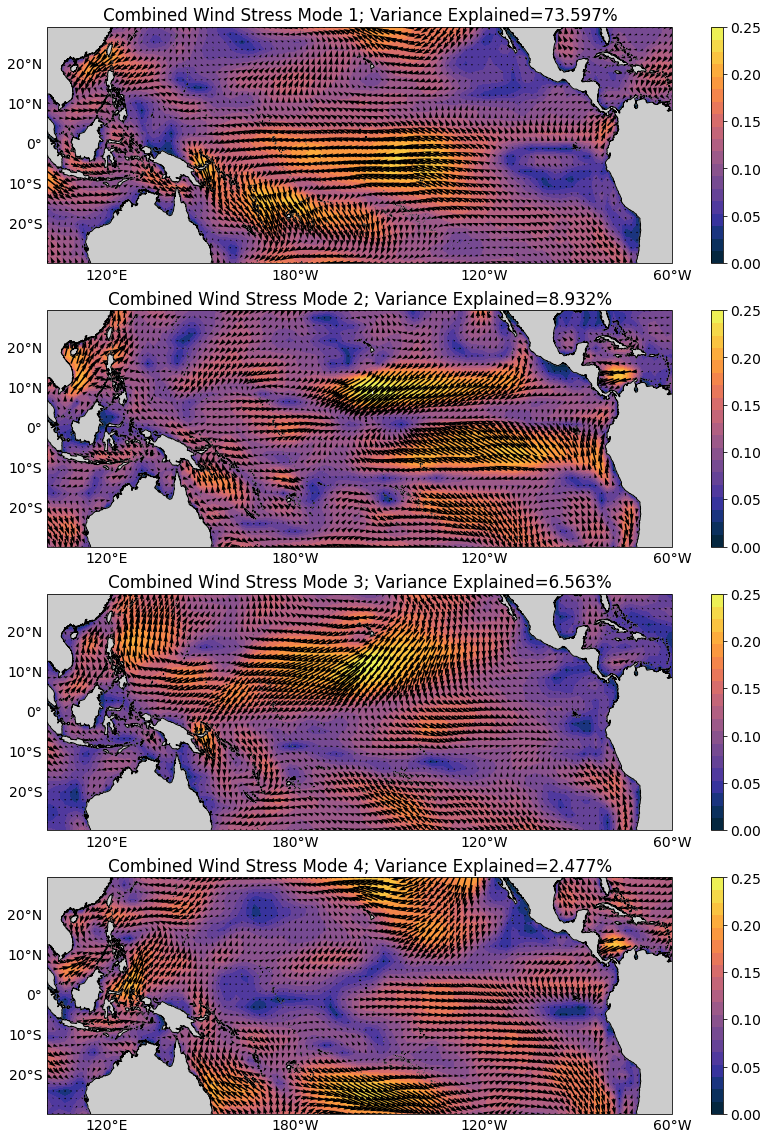

In [13]:
fig,ax = plt.subplots(4,1, figsize = (14,20),  
                      subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-180)},
                    )
for i in range(4):
    wsa = np.sqrt(np.sqrt((uxrs[i,:,:]**2)+(uyrs[i,:,:]**2)))#amplitude
    mappable = ax[i].contourf(lon,
                              lat,
                              wsa,
                              cmap = cmo.thermal,
                              levels=np.linspace(0,0.25,20),
                              transform = ccrs.PlateCarree()
                              )
    quiv =  ax[i].quiver(lon, 
                         lat, 
                         uxrs[i,:,:],
                         uyrs[i,:,:], 
                         transform = ccrs.PlateCarree()
                             )
    #Colorbar & more cartopy
    cb = fig.colorbar(mappable, 
                      ax = ax[i],
                      ticks = [0, 0.05, 0.10, 0.15, 0.20, 0.25],
                      orientation='vertical', 
                      label = ''
                     )
    ax[i].set_aspect('auto')
    ax[i].add_feature(land_10m, facecolor='0.8')
    ax[i].coastlines(resolution='10m')  
    #Gridlines - make it look pretty
    
    ax[i].set_title('Combined Wind Stress Mode '+str(i+1)+'; Variance Explained='+
                        str(round(var[i],3))+'%')
    
    gl = ax[i].gridlines(linewidth=0.4, color='black', alpha=0, draw_labels=True)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False

Note that the above plots are unitless because we normalized the anomalies by their standard deviations.  The first mode likely represents El-Nino and the second mode is La Nina, as relevant in the warmer and cooler anomalies along the equator, respectively. The higher order modes likely require further investigation 

#### Now that the SVD is done we can build the statistical atmosphere model. Isolate the second time series and calculate the anomalize, then normalize by the standard deviation.

In [14]:
ds2 = ds.sel(lat = slice(30,-30),
             lon = slice(100,300),
             time = slice('2000','2017'),
            )

sst2 = ds2.skt.transpose('lat','lon','time')
taux2 = ds2.uflx.transpose('lat','lon','time')
tauy2 = ds2.vflx.transpose('lat','lon','time')


sstm2 = sst2.groupby("time.month").mean("time")
tauxm2 = taux2.groupby("time.month").mean("time")
tauym2 = tauy2.groupby("time.month").mean("time")


ssta2 = np.array(sst2.groupby("time.month")-sstm2)
tauxa2 = np.array(taux2.groupby("time.month")-tauxm2)
tauya2 = np.array(tauy2.groupby("time.month")-tauym2)

sigma_sst2 = ssta2.std()
sigma_taux2 = tauxa2.std()
sigma_tauy2 = tauya2.std()

print('SST2 Standard Deviation: ',sigma_sst2)
print('TauX2 Standard Deviation: ',sigma_taux2)
print('TauY2 Standard Deviation: ',sigma_tauy2)

for i in range(len(ssta2[0,0,:])):
    ssta2[:,:,i] = ssta2[:,:,i]*mask[:,:]
    tauxa2[:,:,i] = tauxa2[:,:,i]*mask[:,:]
    tauya2[:,:,i] = tauya2[:,:,i]*mask[:,:]

SST2 Standard Deviation:  0.7201234
TauX2 Standard Deviation:  0.020931993
TauY2 Standard Deviation:  0.016700527


#### Reshape the data into an mxn array, as we did before. 

In [15]:
T2 = ssta2/sigma_sst2
Tx2 = tauxa2/sigma_taux2
Ty2 = tauya2/sigma_tauy2

T2 = np.reshape(T2, (32*107, 213), order = 'F')

Tx2 = np.reshape(Tx2, (32*107, 213), order = 'F')
Ty2 = np.reshape(Ty2, (32*107, 213), order = 'F')
Ts2 = np.concatenate((Tx2,Ty2), axis=0)

print(np.shape(T2))
print(np.shape(Ts2))

(3424, 213)
(6848, 213)


* Take any SSTA state vector at any given time from the second period, T , normalize it by the standard deviation, and then project it onto a leading SST SVD mode, $v_i$ , to obtain a time series $v_i = <v_i'T>/<v_i'v_i>$

* Take $b_i$ as the corresponding time series for the i th wind stress SVD, $u_i$ , and multiply $b_i$ to $u_i$ ; $b_iu_i$ represents the wind stress variation driven by the $i^{th}$ SST SVD, $v_i$
* Add all $b_iu_i$ for first J (say J=6) leading SDVs, $\Sigma^J b_iu_i$ , and multiply it by the standard deviation of the wind stress; we obtain wind stress anomalies driven by the SST anomaly at that time
* Repeat the above for all time points in the second period, we obtain a wind stress anomaly driven by SSTA during the entire second period

#### To do this - just loop over the 6 SVD modes.

In [16]:
bi = []
for i in range(6):
    bi.append((v[:,i].T@T2[:,:])/((v[:,i].T@v[:,i])))

bi = np.array(bi)

#Obtain biui
biui = np.matmul(u[:,:6],bi)

#### Compute the correlation between the observed wind stress components during the second time series and the model. To do this, split $b_iu_i$ into components, reshape, then multiply by the standard deviation of the anomalies. 

In [17]:
bu_split = np.split(biui,2,axis=0)
taux_m = bu_split[0]
tauy_m = bu_split[1]

taux_m = np.reshape(taux_m, (32,107,213),order='F')
tauy_m = np.reshape(tauy_m, (32,107,213),order='F')

taux2_m = taux_m*sigma_taux
tauy2_m = tauy_m*sigma_tauy

In [18]:
#Get the correlation at each grid cell over all times for the second time series. 
rx = []
ry = []
for j in range(107):
    for i in range(32):
        rx.append(np.corrcoef(taux2_m[i,j,:],tauxa2[i,j,:])[1,0])
        ry.append(np.corrcoef(tauy2_m[i,j,:],tauya2[i,j,:])[1,0])

taurx = np.reshape(np.array(rx),(32,107),order='F')
taury = np.reshape(np.array(ry),(32,107),order='F')

#### Plot the correlations 

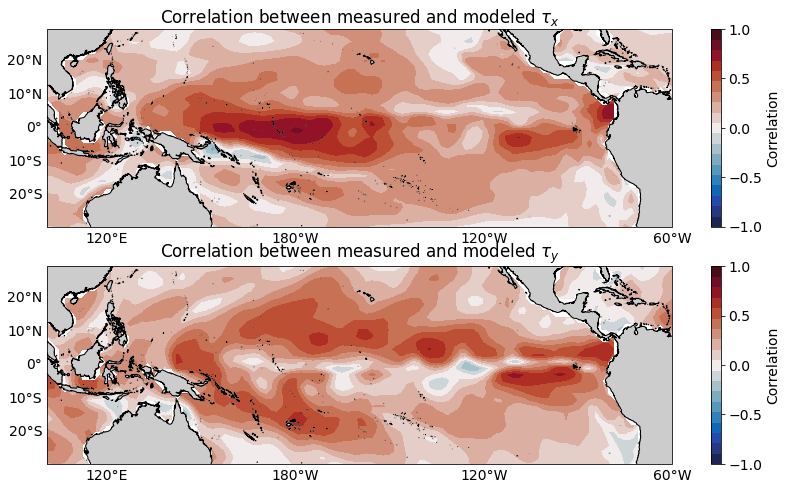

In [19]:

fig,ax = plt.subplots(2, figsize = (14,8),  
                      subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-180)})

mappable =  ax[0].contourf(lon, 
                           lat, 
                           taurx, 
                           levels = np.linspace(-1,1,20),
                           cmap = cmo.balance, 
                           vmin = -1, vmax = 1, 
                           transform = ccrs.PlateCarree()
                           )

mappable =  ax[1].contourf(lon, 
                           lat, 
                           taury, 
                           levels = np.linspace(-1,1,20),
                           cmap = cmo.balance, 
                           vmin = -1, vmax = 1, 
                           transform = ccrs.PlateCarree()
                           )
for i in range(2):
    cb = fig.colorbar(mappable, 
                      ax = ax[i],
                      ticks = [-1, -0.5, 0, 0.5, 1],
                      orientation='vertical', 
                      label = 'Correlation'
                     )
    #More cartopy
    ax[i].set_aspect('auto')
    ax[i].add_feature(land_10m, facecolor='0.8')
    ax[i].coastlines(resolution='10m')  
    #Gridlines - make it look pretty
    gl = ax[i].gridlines(linewidth=0.4, color='black', alpha=0, draw_labels=True)

    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False

    ax[0].set_title(r'Correlation between measured and modeled $\tau_x$')
    ax[1].set_title(r'Correlation between measured and modeled $\tau_y$')

#### Conclusions

What we can see here is that the model performs quite well at simulating the wind stresses, given it's simplicity. Correlations are stronger in the zonal directions and tend to weaken away from the equator. Given that the observed wind stresses converge at the equator, it is expected that the correlation for taux is higher in the zonal direction. Tauy appears to weaken at the equator, as expected, with correlations higher in the northern hemisphere. The patchiness of the variability is likely due to nonlinear processes not captured by the statistical model. Nonetheless, this is extremely valuable for identifying atmospheric modes of variability. 